In [1]:
import numpy as np
import xarray as xr
import torch
import subprocess
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace
sys.path.append("./PatchTST_supervised/")
from types import SimpleNamespace

import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from PatchTST_supervised.models.PatchTST import Model as PatchTSTModel


import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# Utils

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(inputs, targets, outputs, epoch, idx, feature_names, seq_len):
    # Select a sample from the batch to visualize
    sample_index = 0  # You can choose any index from 0 to batch_size-1

    # Detach and move to CPU for visualization
    inputs_sample = inputs[sample_index].cpu().detach().numpy()
    targets_sample = targets[sample_index].cpu().detach().numpy()
    outputs_sample = outputs[sample_index].cpu().detach().numpy()

    # Plotting
    plt.figure(figsize=(5, 3))
    
    for i, feature_name in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i + 1)

        # Time axis
        time_input = np.arange(seq_len)
        time_future = np.arange(seq_len, seq_len + len(targets_sample))
        
        # Plot input, target, and output
        plt.plot(time_input, inputs_sample[:, i], label='Input')
        plt.plot(time_future, targets_sample[:, i], label='Target')
        plt.plot(time_future, outputs_sample[:, i], label='Prediction')

        plt.title(f'Epoch {epoch+1}, Batch {idx+1}, {feature_name}')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [3]:
import torch

def load_checkpoint(model, optimizer, filename="model_checkpoint.pth"):
    """Load a model checkpoint."""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return epoch



# Supervised learning 

## Dataset

In [9]:
NDVI = xr.open_dataarray("Data/ndvi.nc").isel(time=slice(0,729))
ndvi = NDVI.mean(("latitude",  "longitude"))

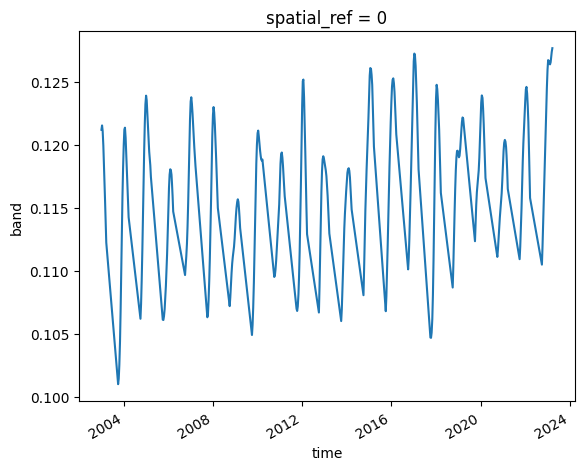

In [14]:
ndvi.plot.line()

In [15]:
ndvi_df  = ndvi.to_dataframe().reset_index()[['time', 'band']]
ndvi_df.rename(columns={'band': 'ndvi'}, inplace=True)
# Set the 'time' column as the index
ndvi_df.set_index('time', inplace=True)

# Normalize the data
scaler = StandardScaler()
ndvi_df['ndvi'] = scaler.fit_transform(ndvi_df[['ndvi']])

In [16]:
class NDVIDataset(Dataset):
    def __init__(self, data, seq_len, prediction_len, scale=True):
        self.seq_len = seq_len
        self.pred_len = prediction_len
        self.data = data
        self.features = data.columns.tolist()
        self.target = 'ndvi'  # You will need to set your target variable here


    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[self.features].iloc[index:index+self.seq_len].values
        y = self.data[self.target].iloc[index+self.seq_len:index+self.seq_len+self.pred_len].values
        
        
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
# Parameters for the dataset
seq_len = 36 # For example, using 6 dekads of data for prediction
prediction_len = 9  # Predict the next 3 dekads
num_features = 1  # Number of features in your dataset (ndvi)

dataset = NDVIDataset(ndvi_df, seq_len, prediction_len)
x, y = dataset[0]
   

The output of this class would be 
* x a tensor of shape [batch_size, seq_length, num_features]
* y a tensor of shape [batch_size, seq_length]


In [17]:
# Create DataLoader for training
batch_size = 64

# Define the size of the splits
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Calculate the number of samples in each set
n = len(ndvi_df)
train_end = int(train_size * n)
val_end = train_end + int(val_size * n)

# Split the data
train_data = ndvi_df[:train_end]
val_data = ndvi_df[train_end:val_end]
test_data = ndvi_df[val_end:]

# Create WeatherDataset instances for each set
train_dataset = NDVIDataset(train_data, seq_len, prediction_len)
val_dataset = NDVIDataset(val_data, seq_len, prediction_len)
test_dataset = NDVIDataset(test_data, seq_len,  prediction_len)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
# Configuration for PatchTSTModel
config = {
    'enc_in': ndvi_df.shape[1],  # Number of features
    'seq_len': seq_len,  # Length of input sequences
    'pred_len': prediction_len,  # Length of prediction
    'e_layers': 3,  # Number of encoder layers
    'n_heads': 8,  # Number of attention heads
    'd_model': 512,  # Model dimensionality
    'd_ff': 2048,  # Dimension of feed-forward network
    'dropout': 0.1,  # Dropout rate
    'fc_dropout': 0.1,  # Fully connected layer dropout
    'head_dropout': 0.1,  # Head dropout
    'individual': True,  # Individual layer normalization
    'patch_len': 3,  # Patch length (should divide seq_len)
    'stride': 1,  # Stride for patches
    'padding_patch': 0,  # Padding for patches
    'revin': True,  # Reversible instance normalization
    'affine': True,  # Affine parameter for instance normalization
    'subtract_last': False,  # Subtract last parameter for reversible instance normalization
    'decomposition': False,  # Whether to use decomposition
    'kernel_size': 3,  # Kernel size for decomposition
    # Additional parameters with their default values from the model
    'max_seq_len': 1024,
    'd_k': 64,
    'd_v': 64,
    'norm': 'BatchNorm',
    'attn_dropout': 0.0,
    'act': 'gelu',
    'key_padding_mask': 'auto',
    'padding_var': None,
    'attn_mask': None,
    'res_attention': True,
    'pre_norm': False,
    'store_attn': False,
    'pe': 'zeros',
    'learn_pe': True,
    'pretrain_head': False,
    'head_type': 'flatten',
    'verbose': False,
}

In [19]:
# Convert the configuration dictionary to an object
config_obj = SimpleNamespace(**config)

# Instantiate the model with the configuration object
model = PatchTSTModel(config_obj).float()




# Step 3: Set up the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Now the model is ready to be trained with your dataset
# Check if GPU is available and move the model to GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=3, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-2): 3 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=512, out_features=512, bias=True)
              (W_K): Linear(in_features=512, out_features=512, bias=True)
              (W_V): Linear(in_features=512, out_features=512, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=512, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
            (norm_attn): Sequential(
             

## Train

In [20]:
def train(model, train_loader, val_loader, num_epochs = 100):
    
    # Check if GPU is available and set the device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the chosen device
    model = model.to(device)

    

    train_losses = []
    average_train_losses = []
    average_val_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        for idx, batch in enumerate(train_loader):
                optimizer.zero_grad()  # Clear gradients from the previous step
                inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model

                # print("*************", epoch, idx)
                # print("Inputs shape", inputs.shape)

                targets = targets.unsqueeze(-1).expand(-1, -1, 1)

                # print("Targets shape", targets.shape)

                outputs = model(inputs.float())  # Forward pass: compute the model output

                # print("Outputs shape", outputs.shape)

                loss = criterion(outputs, targets.float())

                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

                if (idx + 1) % 5 == 0 or (idx + 1) == len(train_loader):
                    visualize(inputs, targets, outputs, epoch, idx, ['NDVI'], seq_len)


        # Compute average training loss
        average_train_loss = sum(train_losses) / len(train_losses)
        average_train_losses.append(average_train_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}")


        # Validation loop (if you have a validation set)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Turn off gradients for validation
            for batch in val_loader:
                inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
                targets = targets.unsqueeze(-1).expand(-1, -1, 1)
                outputs = model(inputs.float())
                # Expand the target tensor to match the output shape
                loss = criterion(outputs, targets.float())
                val_losses.append(loss.item())

            # Compute average validation loss
            average_val_loss = sum(val_losses) / len(val_losses)
            average_val_losses.append(average_val_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}")
            
    return model, train_losses ,average_train_losses ,average_val_losses ,val_losses


In [ ]:
train(model, train_loader, val_loader, num_epochs = 100)

In [22]:
def save_checkpoint(model, optimizer, epoch, filename="model_checkpoint.pth"):
    
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

In [14]:
save_checkpoint(model, optimizer, epoch, filename=f"model_checkpoint_epoch_{epoch+1}.pt")

In [ ]:
plt.plot(train_losses)
plt.title("Training loss")

Text(0.5, 1.0, 'Validation loss')

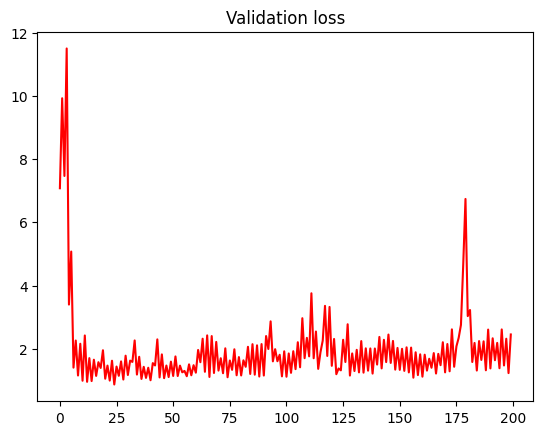

In [23]:
plt.plot(val_losses, color='r')
plt.title("Validation loss")

In [25]:
load_checkpoint(model, optimizer, filename=f"model_checkpoint_epoch_{epoch+1}.pt")
optimizer.lr = 1e-2

In [ ]:
model, train_losses ,average_train_losses ,average_val_losses ,val_losses = train(model, train_loader, val_loader, num_epochs=100)

## Multivariate 

In [4]:
import torch

def save_checkpoint(model, optimizer, epoch, filename="model_checkpoint.pth"):
    """Save a model checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename)


def load_checkpoint(model, optimizer, filename="model_checkpoint.pth"):
    """Load a model checkpoint."""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return epoch



In [5]:
class WeatherDataset(Dataset):
    def __init__(self, data, seq_len, prediction_len, scale=True):
        self.seq_len = seq_len
        self.pred_len = prediction_len
        self.data = data
        self.features = data.columns.tolist()


    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[self.features].iloc[index:index+self.seq_len].values
        y = self.data[self.features].iloc[index+self.seq_len:index+self.seq_len+self.pred_len].values
        
        
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [6]:
NDVI = xr.open_dataarray("Data/ndvi.nc")
RFH = xr.open_dataarray("Data/rfh.nc")

In [7]:
ndvi = NDVI.mean(("latitude",  "longitude"))
rfh = RFH.mean(("latitude",  "longitude"))

In [8]:
ndvi_df  = ndvi.to_dataframe().reset_index()[['time', 'band']]
ndvi_df.rename(columns={'band': 'ndvi'}, inplace=True)
# Set the 'time' column as the index
ndvi_df.set_index('time', inplace=True)

# Normalize the data
scaler = StandardScaler()
ndvi_df['ndvi'] = scaler.fit_transform(ndvi_df[['ndvi']])

rfh_df  = rfh.to_dataframe().reset_index()[['time', 'band']]
rfh_df.rename(columns={'band': 'rfh'}, inplace=True)
# Set the 'time' column as the index
rfh_df.set_index('time', inplace=True)

# Normalize the data
scaler = StandardScaler()
rfh_df['rfh'] = scaler.fit_transform(rfh_df[['rfh']])

In [9]:
df = pd.concat([rfh_df, ndvi_df], axis=1)

In [10]:
seq_len = 36 # For example, using 6 dekads of data for prediction
prediction_len = 9  # Predict the next 3 dekads

dataset = WeatherDataset(ndvi_df, seq_len, prediction_len)
x, y = dataset[0]
   

In [11]:
# Create DataLoader for training
batch_size = 64

# Define the size of the splits
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Calculate the number of samples in each set
n = len(df)
train_end = int(train_size * n)
val_end = train_end + int(val_size * n)

# Split the data
train_data = df[:train_end]
val_data = df[train_end:val_end]
test_data = df[val_end:]

# Create WeatherDataset instances for each set
train_dataset = WeatherDataset(train_data, seq_len, prediction_len)
val_dataset = WeatherDataset(val_data, seq_len,  prediction_len)
test_dataset = WeatherDataset(test_data, seq_len,  prediction_len)

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:



# Configuration example for PatchTSTModel
config = {
    'enc_in': df.shape[1] ,  # Replace with the actual number of features in your dataset
    'seq_len': seq_len ,          # Use the past 24 hours of data to make a prediction
    'pred_len': prediction_len,         # Predict the next 24 hours of data
    'e_layers': 3,          # Number of encoder layers
    'n_heads': 8,           # Number of attention heads
    'd_model': 512,         # Model dimensionality
    'd_ff': 2048,           # Dimension of feed-forward network
    'dropout': 0.1,         # Dropout rate
    'fc_dropout': 0.1,      # Fully connected layer dropout
    'head_dropout': 0.1,    # Head dropout
    'individual': True,     # Individual layer normalization
    'patch_len': 16,        # Patch length
    'stride': 1,            # Stride for patches
    'padding_patch': 0,     # Padding for patches
    'revin': True,          # Reversible instance normalization
    'affine': True,         # Affine parameter for instance normalization
    'subtract_last': False, # Subtract last parameter for reversible instance normalization
    'decomposition': False, # Whether to use decomposition
    'kernel_size': 3,       # Kernel size for decomposition
    # Additional parameters with their default values from the model
    'max_seq_len': 1024,
    'd_k': 64,
    'd_v': 64,
    'norm': 'BatchNorm',
    'attn_dropout': 0.0,
    'act': 'gelu',
    'key_padding_mask': 'auto',
    'padding_var': None,
    'attn_mask': None,
    'res_attention': True,
    'pre_norm': False,
    'store_attn': False,
    'pe': 'zeros',
    'learn_pe': True,
    'pretrain_head': False,
    'head_type': 'flatten',
    'verbose': False,
}



# Convert the configuration dictionary to an object
config_obj = SimpleNamespace(**config)

# Instantiate the model with the configuration object
model = PatchTSTModel(config_obj).float()




# Step 3: Set up the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer with learning rate 0.001

# Now the model is ready to be trained with your dataset
# Check if GPU is available and move the model to GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Model(
  (model): PatchTST_backbone(
    (revin_layer): RevIN()
    (backbone): TSTiEncoder(
      (W_P): Linear(in_features=16, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder): TSTEncoder(
        (layers): ModuleList(
          (0-2): 3 x TSTEncoderLayer(
            (self_attn): _MultiheadAttention(
              (W_Q): Linear(in_features=512, out_features=512, bias=True)
              (W_K): Linear(in_features=512, out_features=512, bias=True)
              (W_V): Linear(in_features=512, out_features=512, bias=True)
              (sdp_attn): _ScaledDotProductAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
              )
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=512, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
            (dropout_attn): Dropout(p=0.1, inplace=False)
            (norm_attn): Sequential(
            

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(inputs, targets, outputs, epoch, idx, feature_names, seq_len):
    # Select a sample from the batch to visualize
    sample_index = 0  # You can choose any index from 0 to batch_size-1

    # Detach and move to CPU for visualization
    inputs_sample = inputs[sample_index].cpu().detach().numpy()
    targets_sample = targets[sample_index].cpu().detach().numpy()
    outputs_sample = outputs[sample_index].cpu().detach().numpy()

    # Plotting
    plt.figure(figsize=(12,3 ),  facecolor='none')

    for i, feature_name in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i + 1)

        # Time axis
        time_input = np.arange(seq_len)
        time_future = np.arange(seq_len, seq_len + len(targets_sample))

        # Plot input, target, and output
        plt.plot(time_input, inputs_sample[:, i], label='Input')
        plt.plot(time_future, targets_sample[:, i], label='Target')
        plt.plot(time_future, outputs_sample[:, i], label='Prediction')

        plt.title(f'Epoch {epoch+1}, Batch {idx+1}, {feature_name}')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [25]:
def train_Patchtst(model,train_loader, val_loader, num_epochs,features_name=['rain(mm)', 'ndvi']):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)



    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        for idx, batch in enumerate(train_loader):
                optimizer.zero_grad()  # Clear gradients from the previous step
                inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model


                outputs = model(inputs.float())  # Forward pass: compute the model output
                loss = criterion(outputs, targets.float())

                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

                if (idx + 1) % 5 == 0 or (idx + 1) == len(train_loader):
                    visualize(inputs, targets, outputs, epoch, idx, features_name, seq_len)


        # Compute average training loss
        average_train_loss = sum(train_losses) / len(train_losses)
        save_checkpoint(model, optimizer, epoch, filename=f"checkpoints/model_checkpoint_epoch_{epoch+1}.pth")
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}")


        # Validation loop (if you have a validation set)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Turn off gradients for validation
            for batch in val_loader:
                inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
                outputs = model(inputs.float())
                # Expand the target tensor to match the output shape
                loss = criterion(outputs, targets.float())
                val_losses.append(loss.item())

            # Compute average validation loss
            average_val_loss = sum(val_losses) / len(val_losses)
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}")


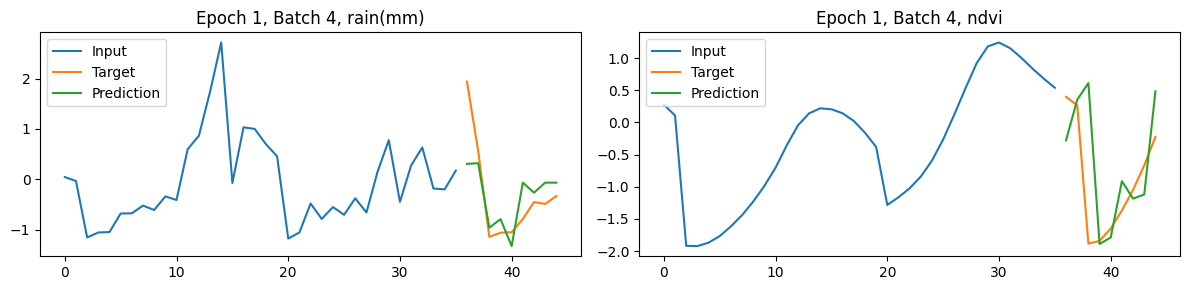

Epoch 1/10, Train Loss: 0.6537
Epoch 1/10, Validation Loss: 0.4961


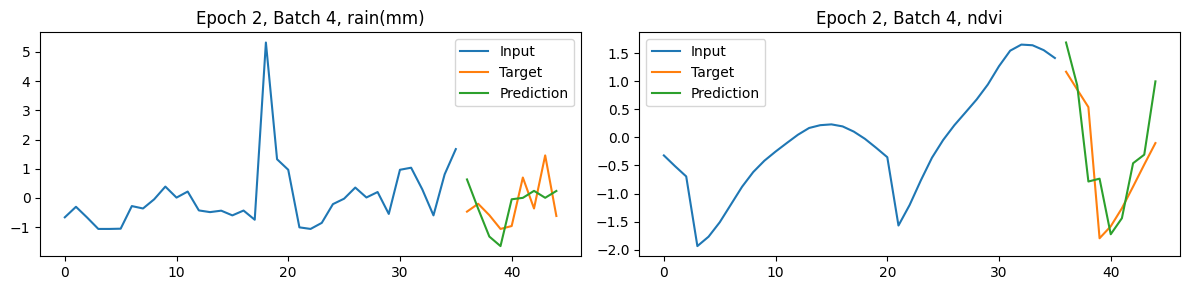

Epoch 2/10, Train Loss: 0.6040
Epoch 2/10, Validation Loss: 0.4727


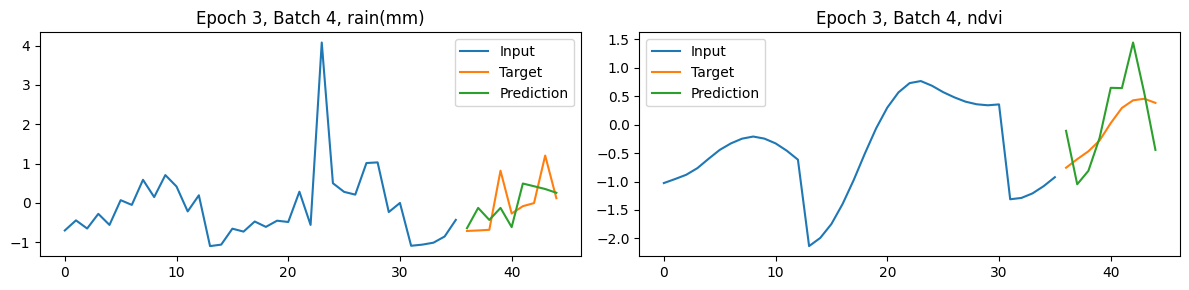

Epoch 3/10, Train Loss: 0.5868
Epoch 3/10, Validation Loss: 0.4837



KeyboardInterrupt



In [26]:
train_Patchtst(model,train_loader, val_loader, num_epochs=10)

In [31]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation
    test_losses = []
    for batch in test_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)  # Move data to the same device as the model
        outputs = model(inputs.float())
        # Expand the target tensor to match the output shape
        loss = criterion(outputs, targets.float())
        test_losses.append(loss.item())


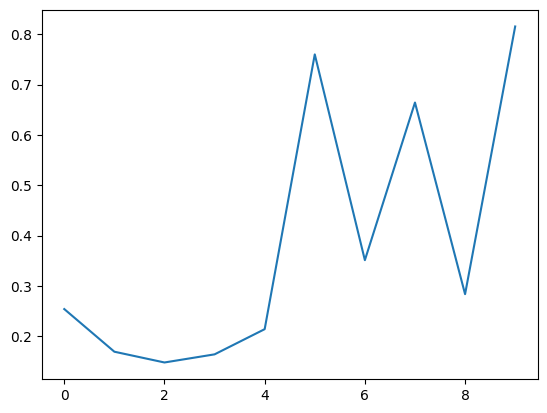

In [36]:
plt.plot(train_losses)

# Self-supervised model

* Complexity of the Task:

Weather forecasting, especially on a global scale, is inherently complex. Self-supervised learning can be advantageous here because it can help the model learn to understand and represent complex patterns in the data, even without explicit labels.

* Data Characteristics:

Time series data, like weather data, often contains inherent patterns and structures (seasonality, trends, etc.). Self-supervised learning can be particularly effective in extracting and leveraging these patterns to improve the model’s understanding of the underlying processes.

* Robustness and Generalization:

Self-supervised learning can potentially lead to more robust models that generalize better to unseen data. This is crucial for global weather forecasting, where the model needs to perform well across a wide range of geographic and climatic conditions.

In [67]:
import sys
sys.path.append("./PatchTST_self_supervised/")
from types import SimpleNamespace
import xarray as xr
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import pandas as pd

from PatchTST_self_supervised.src.models.patchTST import PatchTST
from PatchTST_self_supervised.src.learner import Learner, transfer_weights
from PatchTST_self_supervised.src.callback.tracking import *
from PatchTST_self_supervised.src.callback.patch_mask import *
from PatchTST_self_supervised.src.callback.transforms import *
from PatchTST_self_supervised.src.metrics import *
from PatchTST_self_supervised.src.basics import set_device
from PatchTST_self_supervised.datautils import *

from src.data.datamodule import DataLoaders


In [130]:
config = {
    'c_in' : 2 , #number of variables
    'sequence_length' : 36,
    'prediction_length' : 9,
    'patch_len' : 5, #Length of the patch
    'stride' : 5,
    
    'revin':1, #reversible instance normalization
    'mask_ratio':0.4, # masking ratio for the input
    
    'lr' : 1e-4,
    
    'batch_size':64, 
    'num_workers':0,
    
    'n_epochs_pretrain' : 10, # number of pre-training epochs
    'pretrained_model_id': 1, # id of the saved pretrained model
    
}

config_obj = SimpleNamespace(**config)

## Dataset and Dataloader

In [114]:
class Rain_Ndvi_Dataset(Dataset):
    def __init__(self, dataframe, size=None, split='train', scale=True, features=['rfh', 'ndvi']):
        # size [seq_len, label_len, pred_len]
        if size is None:
            self.seq_len = 30  # Adjust as needed
            self.label_len = 10  # Adjust as needed
            self.pred_len = 10  # Adjust as needed
        else:
            self.seq_len, self.label_len, self.pred_len = size

        assert split in ['train', 'val', 'test']
        self.split = split
        self.scale = scale
        self.features = features

        self.dataframe = dataframe
        self.__read_data__()

    def __read_data__(self):
        df = self.dataframe.copy()

        if self.scale:
            self.scaler = StandardScaler()
            df[self.features] = self.scaler.fit_transform(df[self.features])

        # Split data (adjust the logic as needed based on your specific split requirements)
        train_size = int(0.7 * len(df))
        val_size = int(0.15 * len(df))

        if self.split == 'train':
            self.data = df.iloc[:train_size]
        elif self.split == 'val':
            self.data = df.iloc[train_size:train_size + val_size]
        else:
            self.data = df.iloc[train_size + val_size:]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data.iloc[s_begin:s_end][self.features].values
        seq_y = self.data.iloc[r_begin:r_end][self.features].values

        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        if self.scale:
            return self.scaler.inverse_transform(data)
        return data


In [115]:
NDVI = xr.open_dataarray("Data/ndvi.nc")
RFH = xr.open_dataarray("Data/rfh.nc")
ndvi = NDVI.mean(("latitude",  "longitude"))
rfh = RFH.mean(("latitude",  "longitude"))

ndvi_df  = ndvi.to_dataframe().reset_index()[['time', 'band']]
ndvi_df.rename(columns={'band': 'ndvi'}, inplace=True)
# Set the 'time' column as the index
ndvi_df.set_index('time', inplace=True)

# Normalize the data
scaler = StandardScaler()
ndvi_df['ndvi'] = scaler.fit_transform(ndvi_df[['ndvi']])

rfh_df  = rfh.to_dataframe().reset_index()[['time', 'band']]
rfh_df.rename(columns={'band': 'rfh'}, inplace=True)
# Set the 'time' column as the index
rfh_df.set_index('time', inplace=True)

# Normalize the data
scaler = StandardScaler()
rfh_df['rfh'] = scaler.fit_transform(rfh_df[['rfh']])

df = pd.concat([rfh_df, ndvi_df], axis=1)

In [116]:
dataset_train = Rain_Ndvi_Dataset(df, size=(config_obj.sequence_length, 0, config_obj.prediction_length), split='train', scale=True)

In [117]:
def get_dls(config_obj, dataset_class):
    size = [config_obj.sequence_length, 0, config_obj.prediction_length]
    dls = DataLoaders(
            datasetCls=dataset_class,
            dataset_kwargs={
                'dataframe': df,
                'size':size,
                'scale':True,
                'features':['rfh', 'ndvi']
            },
            batch_size=config_obj.batch_size,
            workers=config_obj.num_workers,
            )

    dls.vars, dls.len = dls.train.dataset[0][0].shape[1], config_obj.sequence_length
    dls.c = dls.train.dataset[0][1].shape[0]
    return dls

## define te model and pretrain

In [118]:
def get_model(config):
    stride  = config.stride    
    # get number of patches
    num_patch = (max(config.sequence_length, config.patch_len)-config.patch_len) // stride + 1    
    print('number of patches:', num_patch)
    
    # get model
    model = PatchTST(c_in=config.c_in,
                target_dim=config.prediction_length,
                patch_len=config.patch_len,
                stride=stride,
                num_patch=num_patch,
                n_layers=4, #number of Transformer layers
                n_heads=16,#number of Transformer heads
                d_model=128, #Transformer d_model
                shared_embedding=True,
                d_ff=512, #Tranformer MLP dimension                       
                dropout=2e-1, #Transformer dropout
                head_dropout=2e-1, #head dropout
                act='relu',
                head_type='pretrain',
                res_attention=False
                )        
    # print out the model size
    print('number of model params', sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model



In [119]:
model = get_model(config_obj)

number of patches: 7
number of model params 795397


number of patches: 7
number of model params 795397
suggested_lr 0.0002477076355991711


0.0002477076355991711

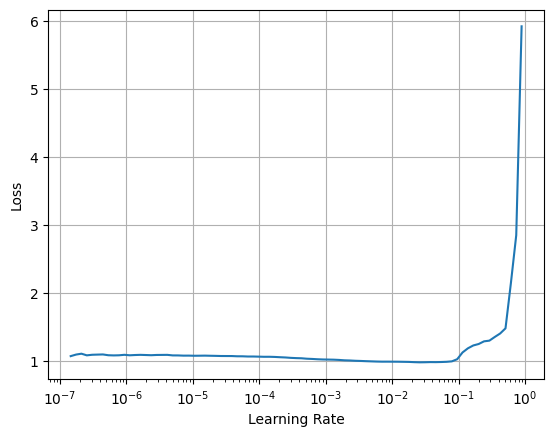

In [124]:
def find_lr(config_obj):
    # get dataloader
    dls = get_dls(config_obj, Rain_Ndvi_Dataset)
    model = get_model(config_obj)
    # get loss
    loss_func = torch.nn.MSELoss(reduction='mean')
    # get callbacks
    cbs = [RevInCB(dls.vars, denorm=False)] if config_obj.revin else []
    cbs += [PatchMaskCB(patch_len=config_obj.patch_len, stride=config_obj.stride, mask_ratio=config_obj.mask_ratio)]
        
    # define learner
    learn = Learner(dls, model, 
                        loss_func, 
                        lr=config_obj.lr, 
                        cbs=cbs,
                        )                        
    # fit the data to the model
    suggested_lr = learn.lr_finder()
    print('suggested_lr', suggested_lr)
    return suggested_lr

find_lr(config_obj)

This method typically involves training the model for a few epochs with a range of learning rates and recording the loss at each step. The learning rate that gives the fastest decrease in loss is considered optimal or near-optimal for the training process.

## Pretrain

In [157]:
def pretrain_func(lr=config_obj.lr):
    
    save_pretrained_model = 'patchtst_pretrained_cw'+str(config_obj.sequence_length)+'_patch'+str(config_obj.patch_len) + '_stride'+str(config_obj.stride) + '_epochs-pretrain' + str(config_obj.n_epochs_pretrain) + '_mask' + str(config_obj.mask_ratio) + '_model' + str(config_obj.pretrained_model_id)
    save_path = 'saved_models' + '/masked_patchtst/' 
    if not os.path.exists(save_path): os.makedirs(save_path)
    
    print(save_path)

    # get dataloader
    dls = get_dls(config_obj, Rain_Ndvi_Dataset)
    # get model
    model = get_model(config_obj)
    # get loss
    loss_func = torch.nn.MSELoss(reduction='mean')
    # get callbacks
    cbs = [RevInCB(dls.vars, denorm=False)] if config_obj.revin else []
    cbs += [
         PatchMaskCB(patch_len=config_obj.patch_len, stride=config_obj.stride, mask_ratio=config_obj.mask_ratio),
         SaveModelCB(monitor='valid_loss', fname=save_pretrained_model,                       
                        path=save_path)
        ]
    # define learner
    learn = Learner(dls, model, 
                        loss_func, 
                        lr=lr, 
                        cbs=cbs,
                        #metrics=[mse]
                        )                        
    # fit the data to the model
    learn.fit_one_cycle(n_epochs=config_obj.n_epochs_pretrain, lr_max=lr)

    train_loss = learn.recorder['train_loss']
    valid_loss = learn.recorder['valid_loss']
    df = pd.DataFrame(data={'train_loss': train_loss, 'valid_loss': valid_loss})
    df.to_csv(save_path + save_pretrained_model + '_losses.csv', float_format='%.6f', index=False)


In [158]:

# Instantiate the model with the configuration object
model = PatchTSTModel(config_obj).float()




# Step 3: Set up the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer with learning rate 0.001

# Now the model is ready to be trained with your dataset
# Check if GPU is available and move the model to GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NameError: name 'PatchTSTModel' is not defined

In [159]:
pretrain_func()

saved_models/masked_patchtst/
number of patches: 7
number of model params 795397
          epoch     train_loss     valid_loss           time
Better model found at epoch 0 with valid_loss value: 1.0322783210060813.
              0       1.105557       1.032278          00:00
Better model found at epoch 1 with valid_loss value: 0.8906327160921964.
              1       1.073694       0.890633          00:00
Better model found at epoch 2 with valid_loss value: 0.8729717081243341.
              2       1.021556       0.872972          00:00
              3       0.997185       0.894022          00:00
Better model found at epoch 4 with valid_loss value: 0.8302153674038973.
              4       0.948688       0.830215          00:00
Better model found at epoch 5 with valid_loss value: 0.8276514573530718.
              5       0.971202       0.827651          00:00
              6       0.915010       0.886772          00:00
              7       0.941687       0.851853          00:00
     

# end